Get the implicit utility function.

In [5]:
struct Calibration
    σ::Float64           # elasticity of relative demand with respect to price         
    γ::Vector{Float64}   # intensity in each good
    ϵ::Vector{Float64}   # elasticity of relative demand with respect to income in luxury good sector
    κ::Vector{Float64}   # For Stone and Geary
    g::Vector{Float64}
end

In [6]:
cal = Calibration(
    0.2,                    # sigma=0.5 completementary goods
    [1/3, 1/3, 1/3],        #intensity
    [0.6, 1.0, 1.65],       #ELASTICITIES
    [0.05, 0.03, 0.02],     #For Stone and Geary
    [1.05, 1.02, 1.01]
)

Calibration(0.2, [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], [0.6, 1.0, 1.65], [0.05, 0.03, 0.02], [1.05, 1.02, 1.01])

In [7]:
ρ=(cal.σ-1)/cal.σ

-4.0

# CES utility function

$$E=\sum^{\mathcal{I}}_{i=1}p_iC_i$$

$$C_i^*= \left(\frac{\gamma_i}{p_i}\right)^\sigma \frac{E}{\sum^{\mathcal{I}}_{i=1}\gamma_i^\sigma p_i^{1-\sigma}}$$

$$U(C_1^*,...,C_I^*)=\left[\sum^{\mathcal{I}}_{i=1}\gamma_iC_i^{* \rho} \right]^{\frac{1}{\rho}}

In [168]:
#Function CES
function CES_Utility(C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    #Budget, expenditure function
    E=sum(p[i]*C[i] for i = 1:length(C))
    
    #CONS
    C1=(cal.γ[1]/p[1])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[i]^(1-cal.σ) for i=1:length(cal.γ)))
    C2=(cal.γ[2]/p[2])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[i]^(1-cal.σ) for i=1:length(cal.γ)))
    C3=(cal.γ[3]/p[3])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[i]^(1-cal.σ) for i=1:length(cal.γ)))

    CB=[C1 C2 C3]
    U=sum(cal.γ[i]*CB[i]^ρ for i=1:length(CB))^(1/ρ)


    #SHARE
    ω_p=(p[1]*C1)/E
    ω_n=(p[2]*C2)/E
    ω_l=(p[3]*C3)/E

    return [U, E, C, [C1, C2, C3], [ω_p, ω_n, ω_l]]
end

CES_Utility (generic function with 1 method)

In [169]:
#Insert an Endowment bundle
U=CES_Utility([10.0, 20.0, 5.0],[5.0, 10.0, 15.0])
println("Utility level reached ", U[1])
println("Expenditure/Wealth level ", U[2])
println("Initial Endowment ", U[3])
println("Optimal Endowment given prices ", U[4])
println("Expenditure share per good ", U[5])

Utility level reached 11.028227225054357
Expenditure/Wealth level 325.0
Initial Endowment [10.0, 20.0, 5.0]
Optimal Endowment given prices [12.623011705751404, 10.988969950935456, 10.133016130792557]
Expenditure share per good [0.19420018008848314, 0.3381221523364756, 0.4676776675750411]


In [171]:
u=[]
C=[]
Co=[]
p=[5.0, 10.0, 15.0]

scale=5.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =CES_Utility([i,j,k],p)
            u=push!(u,res[1])
            Co=push!(Co, res[4])
            C=push!(C,[i j k])
        end
    end
end

H=[u C Co]


125×3 Matrix{Any}:
 1.01799  [1.0 1.0 1.0]  [1.1652, 1.01437, 0.935355]
 1.52699  [1.0 1.0 2.0]  [1.7478, 1.52155, 1.40303]
 2.03598  [1.0 1.0 3.0]  [2.3304, 2.02873, 1.87071]
 2.54498  [1.0 1.0 4.0]  [2.913, 2.53592, 2.33839]
 3.05397  [1.0 1.0 5.0]  [3.4956, 3.0431, 2.80607]
 1.35732  [1.0 2.0 1.0]  [1.5536, 1.35249, 1.24714]
 1.86632  [1.0 2.0 2.0]  [2.1362, 1.85967, 1.71482]
 2.37531  [1.0 2.0 3.0]  [2.7188, 2.36686, 2.1825]
 2.88431  [1.0 2.0 4.0]  [3.3014, 2.87404, 2.65017]
 3.3933   [1.0 2.0 5.0]  [3.884, 3.38122, 3.11785]
 ⋮                       
 3.22364  [5.0 4.0 2.0]  [3.6898, 3.21216, 2.96196]
 3.73263  [5.0 4.0 3.0]  [4.2724, 3.71934, 3.42964]
 4.24163  [5.0 4.0 4.0]  [4.855, 4.22653, 3.89731]
 4.75062  [5.0 4.0 5.0]  [5.43761, 4.73371, 4.36499]
 3.05397  [5.0 5.0 1.0]  [3.4956, 3.0431, 2.80607]
 3.56297  [5.0 5.0 2.0]  [4.0782, 3.55028, 3.27374]
 4.07196  [5.0 5.0 3.0]  [4.6608, 4.05747, 3.74142]
 4.58096  [5.0 5.0 4.0]  [5.2434, 4.56465, 4.2091]
 5.08995  [5.0 5.0 5.0] 

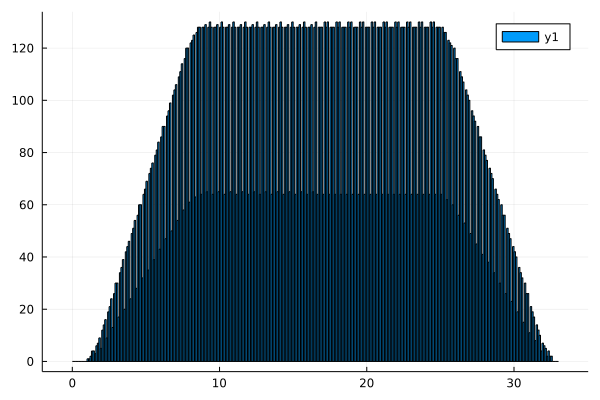

In [50]:
using Plots, Distributions
histogram(H[:,1]; bins = 0:0.1:33)

In [172]:
using DataFrames
function prices(p::Vector{Float64},T::Int64 ;cal=cal)
    #Prices normalized at date t=1
    pp=[p[1]]  #price primary
    pn=[p[2]]  #price normal
    pl=[p[3]]  #price luxury
    #AR(1)
    shock_size=1

    for t=1:T-1
        p_p=p[1]*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=p[2]*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=p[3]*cal.g[3]^(t)+shock_size*randn()

        pnp=p_p/p_n
        pnl=p_l/p_n

        #for matrix
        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)
    end
    return [pp pn pl]
end

T=5
p=prices([5.0, 10.0, 15.0],T)

data=DataFrame(p,:auto)

rename!(data,[:"Primary P",:"Normal P", :"LuxuryP"])

,Primary P,Normal P,LuxuryP
,Float64,Float64,Float64
1,5.0,10.0,15.0
2,5.75036,11.2952,16.378
3,4.60235,11.2212,14.4766
4,6.29034,10.6074,18.4109
5,6.50261,11.5613,13.6665


In [173]:
p

5×3 Matrix{Float64}:
 5.0      10.0     15.0
 5.75036  11.2952  16.378
 4.60235  11.2212  14.4766
 6.29034  10.6074  18.4109
 6.50261  11.5613  13.6665

In [19]:
#Function CES
function CES_UtilityOvertime(C::Vector{Float64}, p::Matrix{Float64}, T::Int64; cal=cal)
    #Budget, expenditure function
    Exp=[]
    Cons=[]
    Share=[]
    Utility=[]

    for t=1:T
        E=sum(p[t,i]*C[i] for i = 1:length(C))
        
        #CONS
        C1=(cal.γ[1]/p[t,1])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[t,i]^(1-cal.σ) for i=1:length(cal.γ)))
        C2=(cal.γ[2]/p[t,2])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[t,i]^(1-cal.σ) for i=1:length(cal.γ)))
        C3=(cal.γ[3]/p[t,3])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[t,i]^(1-cal.σ) for i=1:length(cal.γ)))

        CB=[C1 C2 C3]
        U=sum(cal.γ[i]*CB[i]^ρ for i=1:length(CB))^(1/ρ)


        #SHARE
        ω_p=(p[t,1]*C1)/E
        ω_n=(p[t,2]*C2)/E
        ω_l=(p[t,3]*C3)/E

        ω=[ω_p,ω_n,ω_l]

        Exp=push!(Exp,E)
        Cons=push!(Cons,CB)
        Utility=push!(Utility,U)
        Share=push!(Share, ω)

    end

    return [Utility Exp Cons Share]
end

CES_UtilityOvertime (generic function with 1 method)

In [20]:
V=CES_UtilityOvertime([10.0, 20.0, 5.0], p, 30)

30×4 Matrix{Any}:
 9.15087   800.0    …  [0.0813672, 0.246659, 0.671973]
 9.14676   809.539     [0.0779589, 0.246677, 0.675364]
 9.21199   824.579     [0.0812725, 0.250538, 0.668189]
 9.08707   802.265     [0.0846783, 0.2423, 0.673021]
 9.33963   836.28      [0.0781074, 0.258804, 0.663088]
 9.24558   895.283  …  [0.0968233, 0.251116, 0.652061]
 9.10923   861.686     [0.0972209, 0.242434, 0.660345]
 9.2587    915.446     [0.104592, 0.25102, 0.644389]
 9.27691   924.08      [0.0979464, 0.252956, 0.649097]
 9.24384   936.708     [0.118073, 0.248265, 0.633662]
 ⋮                  ⋱  
 9.54582  1209.05      [0.145771, 0.26248, 0.591749]
 9.45772  1181.34      [0.138057, 0.258424, 0.603519]
 9.57458  1227.55      [0.143256, 0.264688, 0.592056]
 9.49882  1225.42      [0.159767, 0.256945, 0.583288]
 9.44883  1263.85   …  [0.164687, 0.252869, 0.582444]
 9.4677   1300.52      [0.166139, 0.253739, 0.580122]
 9.60201  1313.01      [0.159306, 0.263359, 0.577335]
 9.66674  1392.63      [0.160026, 0.

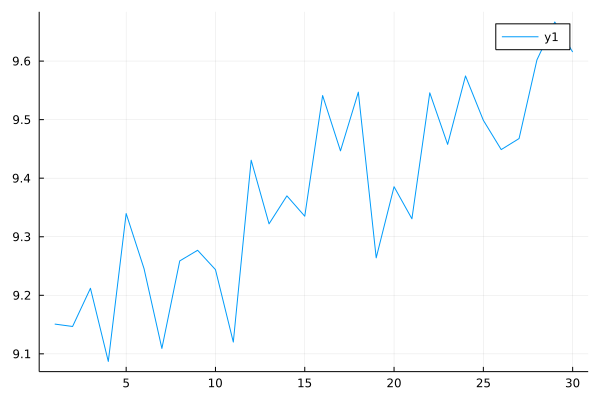

In [21]:
using Plots
#Expenditure / Wealth following fixed endowment
U=V[:,1]
plot(U)

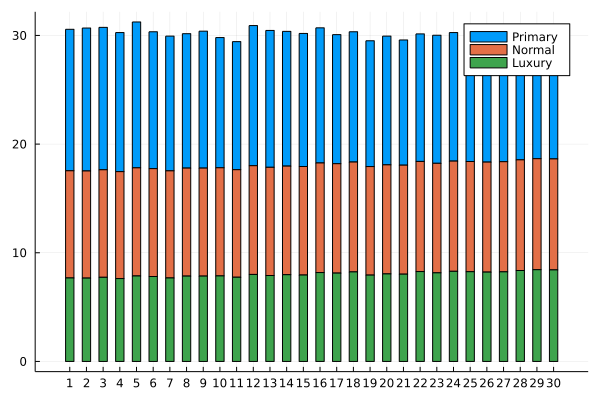

In [22]:
using StatsPlots
T=30
Primary=[]
Normal=[]
Luxury=[]
for t=1:T
    p=V[:,3][t][1]
    n=V[:,3][t][2]
    l=V[:,3][t][3]
    Primary=push!(Primary,p)
    Normal=push!(Normal,n)
    Luxury=push!(Luxury,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary Normal Luxury],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

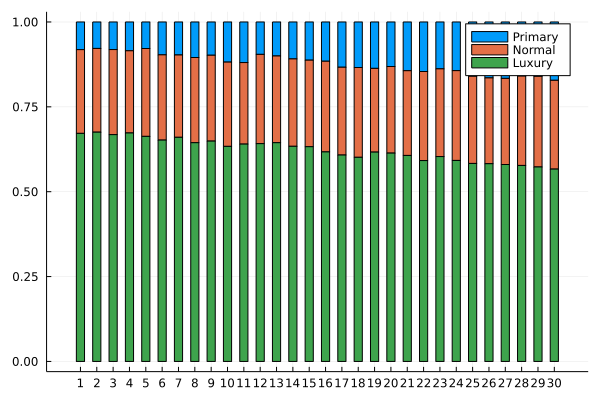

In [23]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=V[:,4][t][1]
    n=V[:,4][t][2]
    l=V[:,4][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

# Stone and Geary

In [7]:
#Function Stone and Geary
function SG(C::Vector{Int64}, cal)
    U=sum(cal.γ[i]*(C[i]+cal.κ[i])^ρ for i=1:length(C))^(1/ρ)
    return U
end

SG (generic function with 1 method)

# Non Homothetic Utility function

In [54]:
p=[5.0, 20.0, 70.0]

3-element Vector{Float64}:
  5.0
 20.0
 70.0

In [6]:
function solvingNH(u, C::Vector{Float64}, p::Matrix{Float64}; cal=cal)
    out=[sum(cal.γ[i]^(1/cal.σ)*(C[i]/u^(cal.ϵ[i]))^ρ for i=1:length(C))-1,
        E-sum(p[i]*C[i] for i=1:length(C)),
        u_c1/p[1]=u_c2/p[2],
        u_c1/p[1]=u_c3/p[3],
        u_c2/p[2]=u_c3/p[3]
        ]
    return out
end

solvingNH(1.0,[1.0,2.0,3.0],p)

ErrorException: syntax: misplaced assignment statement in "[(sum((((cal.γ[i] ^ (1 / cal.σ)) * ((C[i] / (u ^ cal.ϵ[i])) ^ ρ)) for i = 1:length(C))) - 1), (E - sum(((p[i] * C[i]) for i = 1:length(C)))), (u_c1 / p[1]) = begin
    # /Users/antoineding/Documents/GitHub/IIRUHH_master/U_find.ipynb, line 4
    (u_c2 / p[2])
end, (u_c1 / p[1]) = begin
    # /Users/antoineding/Documents/GitHub/IIRUHH_master/U_find.ipynb, line 5
    (u_c3 / p[3])
end, (u_c2 / p[2]) = begin
    # /Users/antoineding/Documents/GitHub/IIRUHH_master/U_find.ipynb, line 6
    (u_c3 / p[3])
end]" around /Users/antoineding/Documents/GitHub/IIRUHH_master/U_find.ipynb:2

In [27]:
p

1×3 Matrix{Float64}:
 5.0  10.0  30.0

In [55]:
using NLsolve

function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    out=sum(cal.γ[i]^(1/cal.σ)*(C[i]/u^(cal.ϵ[i]))^ρ for i=1:length(C))-1
    return out
end

nlsolve(u->[solvingNH(u[1],[10.0, 20.0, 5.0], p)], [1.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0]
 * Zero: [6.096341242450635]
 * Inf-norm of residuals: 0.000000
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 8
 * Jacobian Calls (df/dx): 7

In [56]:
using NLsolve

#UTILITY LEVEL for a given C
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    out=sum(cal.γ[i]^(1/cal.σ)*(C[i]/u^(cal.ϵ[i]))^ρ for i=1:length(C))-1
    return out
end

function NHUtility(C::Vector{Float64}, p::Vector{Float64} ;cal=cal,tol=1e-10,T=100)
    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p[i]*C[i] for i=1:length(C))
    Expmini=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/Expmini)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/Expmini)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/Expmini)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/Expmini)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/Expmini)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/Expmini)^(1-cal.σ)

    #Initial Demand for given endowment level, U initial and minimum expenditure level
    Cinit=[C1,C2,C3]
    ω_init=[ω_p, ω_n, ω_l]

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    #Non homothetic preferences updated expenditure since we still have some wealth unused.
    ExpNH=sum(p[i]*C[i] for i=1:length(C))

    #Non homothetic preferences Expenditure have to coincide with the endowment level wealth.
    if abs(E-ExpNH)>tol
        for j=1:T
            res=nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
            U=res.zero[1]
            
            #DEMAND
            C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/E)^(-cal.σ)
            C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/E)^(-cal.σ)
            C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/E)^(-cal.σ)

            #SHARE
            ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/E)^(1-cal.σ)
            ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/E)^(1-cal.σ)
            ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/E)^(1-cal.σ)
            C=[C1, C2, C3]
            ω=[ω_p, ω_n, ω_l]
    
            ExpNH=sum(p[i]*C[i] for i =1:length(C)) 
        end
        return [U, Uinit, Expmini, E, ExpNH, C, Cinit, ω, ω_init]
    end
end

NHUtility (generic function with 1 method)

In [57]:
NHU=NHUtility([10.0, 20.0, 5.0], p)

9-element Vector{Any}:
   9.14095136726128
   6.096341242450635
 425.84521334297364
 800.0
 799.9999998967196
    [2.6605940347528256, 4.093396955691677, 10.068987008701743]
    [1.9309380800248837, 2.6096274685875325, 5.199971051015693]
    [0.016628712717205157, 0.10233492389229193, 0.8810363632614022]
    [0.02267183027451004, 0.1225622543976208, 0.8547659153278688]

In [58]:
println("NH pref optimal utility level with no waste ", NHU[1])
println("Utility level reached at given endowment ", NHU[2])
println("Above can be reached with minimal cost ", NHU[3])
println("But we have to spend all the wealth so that there is no waste ", NHU[4])
println("Hence NH expenditure will coincide with the wealth ", NHU[5])
println("With bundle (updated) ", NHU[6])
println("Whereas endowment level utility can be reached with this bundle ", NHU[7])
println("Optimal share with no waste ", NHU[8])
println("Optimal share initial with waste ", NHU[9])

NH pref optimal utility level with no waste 9.14095136726128
Utility level reached at given endowment 6.096341242450635
Above can be reached with minimal cost 425.84521334297364
But we have to spend all the wealth so that there is no waste 800.0
Hence NH expenditure will coincide with the wealth 799.9999998967196
With bundle (updated) [2.6605940347528256, 4.093396955691677, 10.068987008701743]
Whereas endowment level utility can be reached with this bundle [1.9309380800248837, 2.6096274685875325, 5.199971051015693]
Optimal share with no waste [0.016628712717205157, 0.10233492389229193, 0.8810363632614022]
Optimal share initial with waste [0.02267183027451004, 0.1225622543976208, 0.8547659153278688]


In [61]:
u=[]
Cendow=[]
C=[]

scale=20.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =NHUtility([i,j,k],p)
            u=push!(u,res[1])
            Cendow=push!(Cendow,[i j k])
            C=push!(C,res[6])
        end
    end
end

NH=[u Cendow C]

8000×3 Matrix{Any}:
  2.2663   [1.0 1.0 1.0]     [0.889574, 0.875935, 1.04333]
  3.27848  [1.0 1.0 2.0]     [1.18605, 1.31434, 1.8969]
  4.13947  [1.0 1.0 3.0]     [1.42374, 1.69997, 2.76974]
  4.90887  [1.0 1.0 4.0]     [1.62786, 2.05267, 3.65439]
  5.61451  [1.0 1.0 5.0]     [1.80951, 2.38193, 4.54734]
  6.27218  [1.0 1.0 6.0]     [1.97478, 2.69327, 5.44658]
  6.89193  [1.0 1.0 7.0]     [2.1274, 2.99025, 6.35083]
  7.48063  [1.0 1.0 8.0]     [2.2699, 3.27533, 7.2592]
  8.04326  [1.0 1.0 9.0]     [2.40403, 3.55031, 8.17105]
  8.58356  [1.0 1.0 10.0]    [2.53112, 3.81658, 9.0859]
  ⋮                          
 12.6888   [20.0 20.0 12.0]  [3.45261, 5.89971, 17.2106]
 13.1045   [20.0 20.0 13.0]  [3.54234, 6.11578, 18.1425]
 13.5123   [20.0 20.0 14.0]  [3.62984, 6.32861, 19.0754]
 13.9128   [20.0 20.0 15.0]  [3.71527, 6.53839, 20.0094]
 14.3065   [20.0 20.0 16.0]  [3.79877, 6.74531, 20.9443]
 14.6937   [20.0 20.0 17.0]  [3.88048, 6.94952, 21.8801]
 15.0748   [20.0 20.0 18.0]  [3.96048, 7.

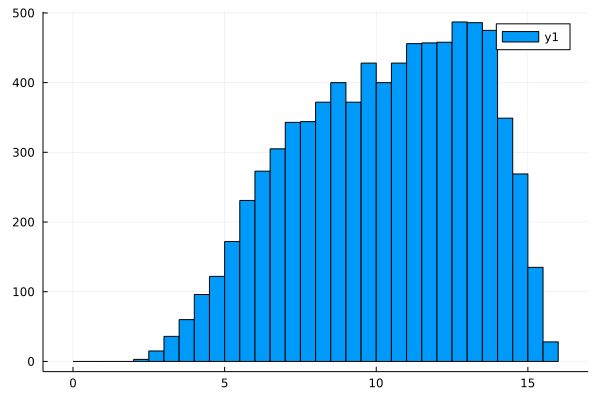

In [62]:
using Plots, Distributions
histogram(NH[:,1]; bins = 0:0.5:16)

In [66]:
p

3-element Vector{Float64}:
  5.0
 20.0
 70.0

In [67]:
#Price dynamics
using Plots, DataFrames

function pricedynamics(p, T::Int64;cal=cal,N=3)
#Time and number of household considered
    #Get our price level dynamics
    shock_size=2
    index=100.0 
    pp=[p[1]]  #price primary
    pn=[p[2]]  #price normal
    pl=[p[3]]  #price luxury
    agg=[1/N*(p[1]+p[2]+p[3])] #aggregate price with homothetic

    for t=1:T-1
        p_p=p[1]*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=p[2]*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=p[3]*cal.g[3]^(t)+shock_size*randn()
        agg_p=0.333*p_p+0.333*p_n+0.333*p_l #share coming from homothetic consumption bundle

        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)
        agg=push!(agg,agg_p)
    end

    pricesplot = [pp pn pl agg]
    return plot(pricesplot, title="Prices dynamics", label=["Primary" "Normal" "Luxury" "Aggregate"], lw=2)
end
    

pricedynamics (generic function with 2 methods)

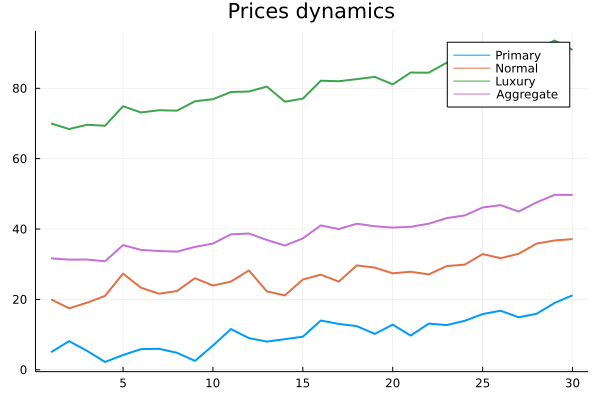

In [68]:
pricedynamics(p,30)

In [160]:
p=[5.0, 10.0, 15.0]

3-element Vector{Float64}:
  5.0
 10.0
 15.0

In [161]:
function prices(T::Int64 , p::Vector{Float64};cal=cal)
    #Prices normalized at date t=1
    pp=[p[1]]  #price primary
    pn=[p[2]]  #price normal
    pl=[p[3]]  #price luxury
    #Relative prices
    pnp_r=[1.0]
    pnl_r=[1.0]
    #AR(1)
    shock_size=1

    for t=1:T-1
        p_p=p[1]*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=p[2]*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=p[3]*cal.g[3]^(t)+shock_size*randn()

        pnp=p_p/p_n
        pnl=p_l/p_n

        #for matrix
        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)

        pnp_r=push!(pnp_r,pnp)
        pnl_r=push!(pnl_r,pnl)
        
    end
    return [pp pn pl]
end

T=5
p=prices(T, p)

data=DataFrame(p,:auto)

rename!(data,[:"Primary P",:"Normal P", :"LuxuryP"])

,Primary P,Normal P,LuxuryP
,Float64,Float64,Float64
1,5.0,10.0,15.0
2,4.93791,11.1078,13.9356
3,5.98463,10.9945,15.5889
4,4.86282,11.0011,16.9159
5,5.57117,10.0337,13.7508


In [162]:
p

5×3 Matrix{Float64}:
 5.0      10.0     15.0
 4.93791  11.1078  13.9356
 5.98463  10.9945  15.5889
 4.86282  11.0011  16.9159
 5.57117  10.0337  13.7508

In [163]:
function NHUtilityExp(C::Vector{Float64}, p::Vector{Float64}, E; cal=cal,tol=1e-10,T=100)
    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    #Minimum expenditure for the utility at given endowment level
    Expmini=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/Expmini)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/Expmini)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/Expmini)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/Expmini)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/Expmini)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/Expmini)^(1-cal.σ)

    #Initial Demand for given endowment level, U initial and minimum expenditure level
    Cinit=[C1,C2,C3]
    ω_init=[ω_p, ω_n, ω_l]

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    #Non homothetic preferences updated expenditure since we still have some wealth unused.
    ExpNH=sum(p[i]*C[i] for i=1:length(C))

    #Non homothetic preferences Expenditure have to coincide with the endowment level wealth.
    if abs(E-ExpNH)>tol
        for j=1:T
            res=nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
            U=res.zero[1]
            
            #DEMAND
            C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/E)^(-cal.σ)
            C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/E)^(-cal.σ)
            C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/E)^(-cal.σ)

            #SHARE
            ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/E)^(1-cal.σ)
            ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/E)^(1-cal.σ)
            ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/E)^(1-cal.σ)

            C=[C1, C2, C3]
            ω=[ω_p, ω_n, ω_l]
    
            ExpNH=sum(p[i]*C[i] for i =1:length(C)) 
        end
        return [U, ExpNH, C, ω] #[U, Uinit, miniEforUinit, E,  ExpNH, C, Cinit, ω, ω_init]
    end
end

NHUtilityExp (generic function with 1 method)

In [164]:
p

5×3 Matrix{Float64}:
 5.0      10.0     15.0
 4.93791  11.1078  13.9356
 5.98463  10.9945  15.5889
 4.86282  11.0011  16.9159
 5.57117  10.0337  13.7508

In [165]:
function NHUtilitytime(C::Vector{Float64}, p::Matrix{Float64}, T::Int64;cal=cal,tol=1e-10)
    Exp=[]
    miniExp=[]
    Cons=[]
    Share=[]
    NH=[]
    Utility=[]

    #Utility level for given C
    res = nlsolve(u->[solvingNH(u[1], C, p[1,:])], [1.0])
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    for t=1:T
        #Wealth level
        E=sum(p[t,i]*C[i] for i = 1:length(C))
        
        #Minimum expenditure for the utility at given endowment level
        miniEforUinit=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (p[t,i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
        
        #Optimal demand with income effect
        c_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[t,1]/miniEforUinit)^(-cal.σ)
        c_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[t,2]/miniEforUinit)^(-cal.σ)
        c_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[t,3]/miniEforUinit)^(-cal.σ)
        
        #Expenditure share with income effect
        ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[t,1]/miniEforUinit)^(1-cal.σ)
        ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[t,2]/miniEforUinit)^(1-cal.σ)
        ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[t,3]/miniEforUinit)^(1-cal.σ)
        
        Consumption=[c_p, c_n, c_l]
        ω=[ω_p, ω_n, ω_l]
    
        price=p[t,:]
        res=nlsolve(u->[solvingNH(u[1], Consumption, price)], [1.0])
        U=res.zero[1]
        NHmax=NHUtilityExp(Consumption, price, E)

        Cons=push!(Cons, Consumption)
        Share=push!(Share, ω)
        Utility=push!(Utility, U)
        Exp=push!(Exp,E)
        miniExp=push!(miniExp,miniEforUinit)
        NH=push!(NH, NHmax)
    end

    #STORE VALUE
    value=[]
    for v=1:4
        for t =1:T
        val=NH[t][v]
        value=push!(value,val)
        end
    end
    NH=(reshape(value,T,4))

    return [Utility Cons Share NH]
end

NHUtilitytime (generic function with 2 methods)

In [166]:
p

5×3 Matrix{Float64}:
 5.0      10.0     15.0
 4.93791  11.1078  13.9356
 5.98463  10.9945  15.5889
 4.86282  11.0011  16.9159
 5.57117  10.0337  13.7508

In [180]:
u=[]
Cendow=[]
C=[]
umin=[]
share=[]
T=5
scale=5.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =NHUtilitytime([i,j,k],p, T)
            u=push!(u,res[T,4])
            Cendow=push!(Cendow,[i j k])
            C=push!(C,res[T,6])
            share=push!(share,res[T,7])
        end
    end
end

NH=[u share C]

125×3 Matrix{Any}:
 2.44267  [0.143994, 0.303665, 0.552341]   [0.702638, 0.833423, 1.2824]
 3.20469  [0.12317, 0.283329, 0.593501]    [0.859891, 1.11253, 1.97147]
 3.89524  [0.109585, 0.268322, 0.622093]   [0.995363, 1.37078, 2.68854]
 4.53458  [0.0997968, 0.256533, 0.643671]  [1.1162, 1.6138, 3.42546]
 5.13463  [0.092299, 0.246885, 0.660816]   [1.22632, 1.84495, 4.17752]
 3.09265  [0.125772, 0.286038, 0.58819]    [0.837337, 1.07108, 1.86322]
 3.79258  [0.111376, 0.270387, 0.618236]   [0.975576, 1.3321, 2.57663]
 4.43889  [0.101129, 0.258189, 0.640682]   [1.09836, 1.57721, 3.31086]
 5.04442  [0.0933411, 0.24826, 0.658399]   [1.20995, 1.81002, 4.06082]
 5.6174   [0.0871557, 0.239928, 0.672916]  [1.31294, 2.03289, 4.82328]
 ⋮                                         
 5.94539  [0.0840258, 0.23555, 0.680424]   [1.37089, 2.16151, 5.28203]
 6.47765  [0.079467, 0.228968, 0.691565]   [1.46353, 2.37177, 6.06009]
 6.98922  [0.075594, 0.223171, 0.701235]   [1.55108, 2.57554, 6.84605]
 7.48282  [0

In [175]:
u=[]
Cendow=[]
C=[]
umin=[]
share=[]
T=5
scale=5.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res = CES_UtilityOvertime([i, j, k], p, T)
            u=push!(u,res[T,1])
            C=push!(C,res[T,3])
            share=push!(share,res[T,4])
        end
    end
end

X=[u share C]

125×3 Matrix{Any}:
 1.00883  [0.227468, 0.360457, 0.412075]  [1.10996 0.989291 0.956739]
 1.44334  [0.227468, 0.360457, 0.412075]  [1.58803 1.41539 1.36881]
 1.87785  [0.227468, 0.360457, 0.412075]  [2.0661 1.84148 1.78089]
 2.31236  [0.227468, 0.360457, 0.412075]  [2.54416 2.26758 2.19296]
 2.74687  [0.227468, 0.360457, 0.412075]  [3.02223 2.69367 2.60504]
 1.37641  [0.227468, 0.360457, 0.412075]  [1.51438 1.34975 1.30534]
 1.81092  [0.227468, 0.360457, 0.412075]  [1.99245 1.77584 1.71741]
 2.24543  [0.227468, 0.360457, 0.412075]  [2.47052 2.20194 2.12949]
 2.67994  [0.227468, 0.360457, 0.412075]  [2.94859 2.62803 2.54156]
 3.11445  [0.227468, 0.360457, 0.412075]  [3.42666 3.05413 2.95363]
 ⋮                                        
 3.37304  [0.227468, 0.360457, 0.412075]  [3.71117 3.30771 3.19888]
 3.80755  [0.227468, 0.360457, 0.412075]  [4.18924 3.73381 3.61095]
 4.24206  [0.227468, 0.360457, 0.412075]  [4.66731 4.1599 4.02303]
 4.67657  [0.227468, 0.360457, 0.412075]  [5.14538 4.5

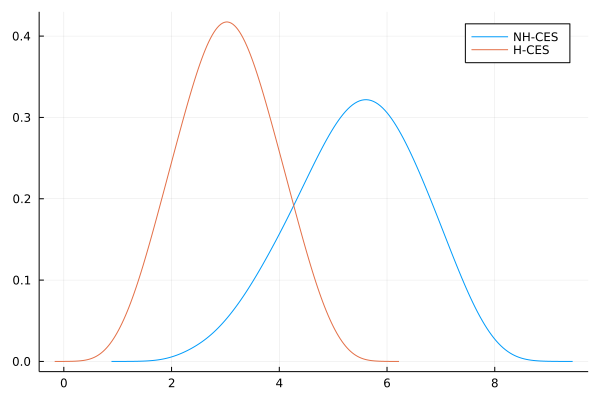

In [195]:
using Plots, Distributions, StatsPlots
density(NH[:,1], label="NH-CES" )
density!(X[:,1], label="H-CES")

In [146]:
res=NHUtilitytime([10.0, 10.0, 10.0],p,5)

5×7 Matrix{Any}:
 9.27491  [1.69357, 3.45416, 10.9987]  …  [0.0787292, 0.184546, 0.736725]
 9.27491  [1.85019, 3.30073, 11.0452]     [0.0563414, 0.223476, 0.720183]
 9.27491  [1.49884, 3.22341, 11.6191]     [0.114517, 0.235117, 0.650366]
 9.27491  [1.49971, 3.43992, 11.2975]     [0.117018, 0.181442, 0.70154]
 9.27491  [1.51984, 3.39357, 11.3126]     [0.111653, 0.192152, 0.696195]

In [95]:
Umin=X[:,[1,4]];
C=X[:,[2,6]];
Share=X[:,[3,7]];
Exp=X[:,5];

In [96]:
C

5×2 Matrix{Any}:
 [1.93094, 2.60963, 5.19997]  [2.66059, 4.0934, 10.069]
 [1.97927, 2.65368, 5.18476]  [2.66793, 4.03526, 9.59025]
 [1.90682, 2.60845, 5.20209]  [2.63347, 4.10506, 10.1224]
 [2.06734, 2.56985, 5.20355]  [2.87764, 4.08887, 10.2887]
 [2.037, 2.58072, 5.20183]    [2.82521, 4.08541, 10.209]

In [97]:
Exp

5-element Vector{Any}:
 799.9999998967196
 775.3196416890786
 838.8408292478505
 862.0521156107792
 851.1325855589687

In [98]:
Umin

5×2 Matrix{Any}:
 6.09634  9.14095
 6.09634  8.88545
 6.09634  9.16886
 6.09634  9.25856
 6.09634  9.21628

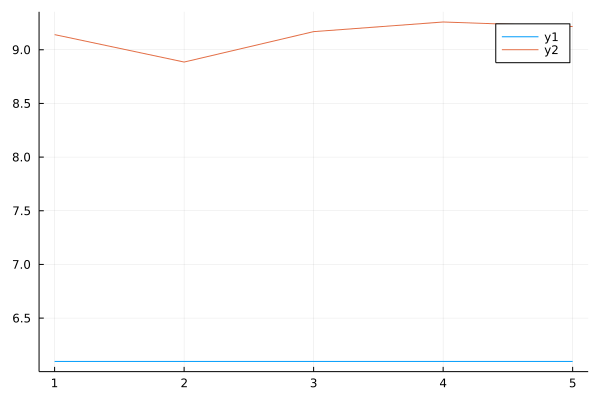

In [99]:
plot(Umin[:,1])
plot!(Umin[:,2])

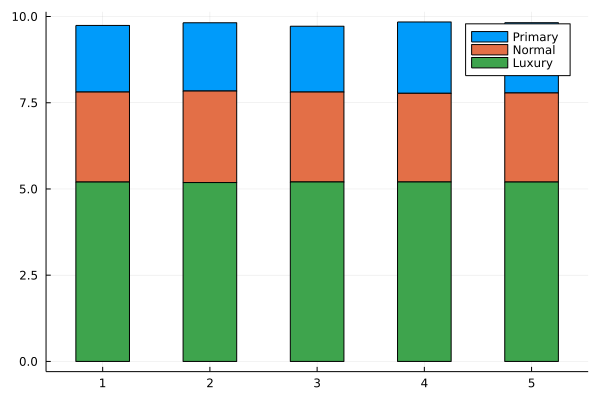

In [100]:
using StatsPlots
Primary=[]
Normal=[]
Luxury=[]
for t=1:T
    p=C[:,1][t][1]
    n=C[:,1][t][2]
    l=C[:,1][t][3]
    Primary_s=push!(Primary,p)
    Normal_s=push!(Normal,n)
    Luxury_s=push!(Luxury,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary Normal Luxury],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

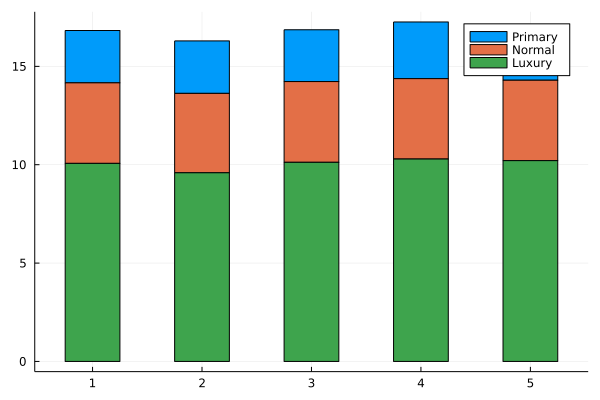

In [102]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=C[:,2][t][1]
    n=C[:,2][t][2]
    l=C[:,2][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

In [103]:
Share

5×2 Matrix{Any}:
 [0.0226718, 0.122562, 0.854766]  [0.0166287, 0.102335, 0.881036]
 [0.020537, 0.114625, 0.864838]   [0.0153649, 0.0967444, 0.887891]
 [0.0238407, 0.122783, 0.853376]  [0.0174517, 0.102418, 0.88013]
 [0.017255, 0.130329, 0.852416]   [0.0125301, 0.108182, 0.879288]
 [0.0183062, 0.128147, 0.853546]  [0.0133391, 0.106579, 0.880082]

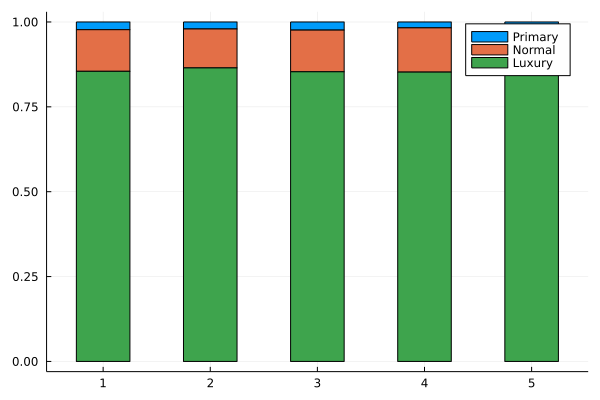

In [104]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=Share[:,1][t][1]
    n=Share[:,1][t][2]
    l=Share[:,1][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

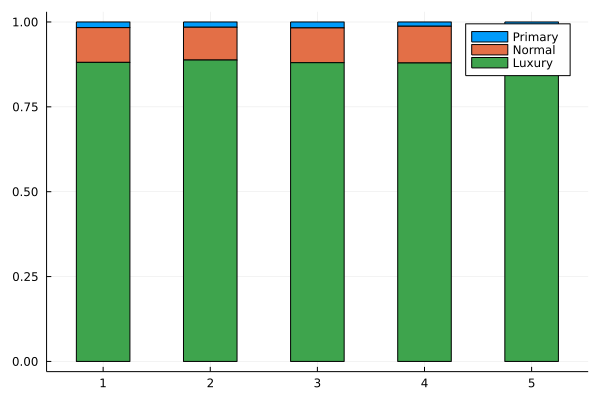

In [105]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=Share[:,2][t][1]
    n=Share[:,2][t][2]
    l=Share[:,2][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])